# Data Drift Dashboard
Here we will go back to using EvidentlyAI to create a proof of concept data drift dashboard. We will use the full training data as reference and the full five validation cohorts as analysis for this example.

In [2]:
import pickle
import numpy as np
import re
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt;
import warnings; warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import os
import sys
import gcsfs
sys.path.append(os.path.abspath("/home/jupyter/POM-feature-drift"))

In [3]:
import nannyml as nml
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset
from evidently import ColumnMapping

In [4]:
# Full reference data, will need to generate different reports for different treatments as the models are trained on different data.
ref = pd.read_csv('gs://andrew-pom/Revenue/ta_step_up_v2_clean.csv', low_memory = False)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [15]:
ref.treatment_type.value_counts()

NT    455582
L      71951
M      71487
H      71466
Name: treatment_type, dtype: int64

## LOW TA
Just doing the one treatment as a test, will look more into how to run it for the different treatments 

### Using built in EvidentlyAI dashboards

In [ ]:
analysis = pd.read_csv('data/ta_low_reference_full.csv', low_memory = False)

In [ ]:
analysis.timestamp = pd.to_datetime(analysis.timestamp)
analysis.sort_values(by = 'timestamp', inplace = True)

In [5]:
with open('pickle_files/DTV_UK_ta_L.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)
features = model.feature_name_

In [34]:
low_ref = ref[ref.treatment_type == 'L']
dates = []
for index in low_ref.ind:
    dates.append(index.split('-')[0])

timestamps = []
for i, date in enumerate(dates):
    timestamps.append(pd.to_datetime(str(dates[i]) + '-0', format = '%Y%W-%w'))
low_ref['timestamp'] = timestamps
low_ref = low_ref[features + ['timestamp']]


In [45]:
low_ref.sort_values(by = 'timestamp', inplace = True)

In [37]:
# column_mapping = ColumnMapping()
# column_mapping.datetime = 'timestamp'

In [49]:
drift_report = Report(metrics=[DataDriftPreset()])

SyntaxError: invalid syntax (4179803666.py, line 1)

In [64]:
drift_report.run(reference_data = low_ref, current_data = analysis[features])

In [48]:
drift_report.save_html('drift_reports/ta_low.html')

In [51]:
drift_report.save_json('drift_reports/ta_low.json')

### Using JSON to create custom plots
The idea of this test is to think about what we would want displayed on a Tableau dashboard. Could either get the required information out of the JSON file and into a BigQuery table for use in Tableau, or see if we can implement into Tableau directly from the JSON.

In [59]:
sorted_features = features.copy()

In [60]:
sorted_features.sort()

In [65]:
validation_cohorts = ['202045-202052', '202053-202107', '202108-202111', '202116-202119', '292124-202127']

for cohort in validation_cohorts:
    gcs_path = f'gs://andrew-pom/Revenue/ta_step_up_low_v2_{cohort}_oot.csv'
    cohort_df = pd.read_csv(gcs_path, low_memory = False)

    dates = []
    for index in cohort_df.ind:
        dates.append(index.split('-')[0])

    timestamps = []
    for i, date in enumerate(dates):
        timestamps.append(pd.to_datetime(str(dates[i]) + '-0', format = '%Y%W-%w'))
    cohort_df['timestamp'] = timestamps

    cohort_df.drop(columns = ['ind', 'xgb_preds', 'xgb_proba', 'logr_preds', 'logr_proba'], inplace = True)
    cohort_df.rename(columns = {'lgbm_preds': 'pred_ta', 'lgbm_proba': 'pred_proba_ta'}, inplace = True)
    cohort_df.sort_values(by = 'timestamp', inplace = True)
    
    drift_report.run(reference_data = low_ref, current_data = cohort_df[features])
    drift_report.save_json(f'drift_reports/ta_low_{cohort}.json')

In [12]:
import json

In [42]:
drift_df = pd.DataFrame()

In [43]:
# Creates DataFrame that can be used for our analysis over time tables.
validation_cohorts = ['202045-202052', '202053-202107', '202108-202111', '202116-202119', '292124-202127']
for cohort in validation_cohorts:
    df = pd.DataFrame(data = {'Feature': features, 'Stattest': None, 'Drift_Score': None, 'Cohort': None})
    for i, feature in enumerate(features):
        with open(f'drift_reports/ta_low_{cohort}.json', 'r') as file:
            report = json.load(file)
        
        #df.Feature = features
        df.iloc[i, 1] = report['metrics'][1]['result']['drift_by_columns'][feature]['stattest_name']
        df.iloc[i, 2] = report['metrics'][1]['result']['drift_by_columns'][feature]['drift_score']
        df.iloc[i, 3] = cohort
        
    drift_df = pd.concat([drift_df, df])
drift_df.reset_index(inplace = True, drop = True)

NameError: name 'arpu_drift' is not defined

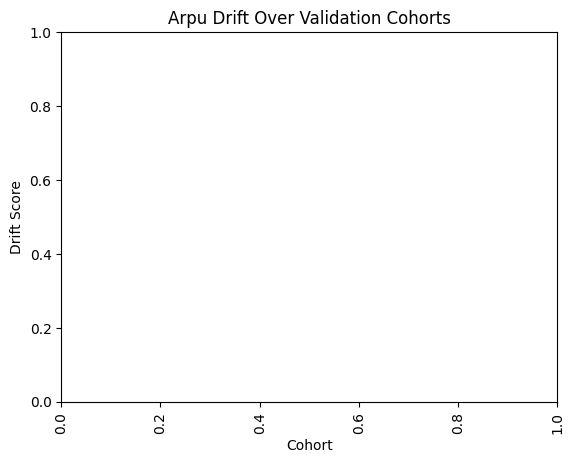

In [27]:
plt.xticks(rotation = '90')
plt.ylabel('Drift Score')
plt.xlabel('Cohort')
plt.title('Arpu Drift Over Validation Cohorts')
plt.plot(validation_cohorts, arpu_drift)